In [1]:
!pip install -q plotnine
!pip install -q vaderSentiment
!pip install -q wordfreq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 28.4 MB/s eta 0:00:00


In [2]:
from googleapiclient.discovery import build
from google.colab import drive
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from plotnine import *
from collections import Counter
import wordfreq
import googleapiclient.discovery
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np



# Videos analyzed:
- https://www.youtube.com/watch?v=ceKMnyMYIMo
11958 comments.
# Videos to analyze:
- https://www.youtube.com/watch?v=v9WSjE3tIkg

# TO DO!
- train VaderSentiment with ground truth

# Data Ingestion

In [3]:

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
clean_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/clean_data.csv",
                         header=0, lineterminator='\n', usecols=["COMMENT"])

In [5]:
clean_data.head(25)

,COMMENT
0,oh u are weird
1,for 6 fucking minutes stop trying to be bo bur...
2,we all make mistakes this new generation of ...
3,huh?? what??? girl
4,this whole entire situation is exposing the da...
5,colleen you made kids put their hands down yo...
6,i feel like i’m watching a dramatized episode ...
7,be so fucking serious right now
8,my jaw is on the floor and not in a good way 🫠
9,what 😀 the 😀 actual 😀 fuck 😀


# Unsupervised learning in Sentiment Analysis
Using Vader NLP model.

In [6]:
analyzer = SentimentIntensityAnalyzer()

In [7]:
def sentiment_analyzer_scores(sentence, printable_output:True):
    score = analyzer.polarity_scores(sentence)
    if printable_output:
        print("{:-<40} {}".format(sentence, str(score)))
    return score['compound']

In [8]:
# TESTING THE SENTIMENT_ANALYZER with ambiguous sentences
sentiment_analyzer_scores('yo this kinda a bop😜😍 ', True) #this is probably sarcasm but also ambiguous
sentiment_analyzer_scores('Really nice caitleen, next time pull out a whole piano to sing your song', True)
#unfortunately, the last sarcastic sentence is not evaluated as negative. It's sarcastic because of elements of overly positive complimenting "really nice <name>, next time do x exaggerating it"
sentiment_analyzer_scores('this cannot be real come on', True) #also this is not evaluated in any way, but it is ambiguous.
sentiment_analyzer_scores("This sentence is really hateful and stupid, horrible, disgusting. I am happy and I am so grateful for this sentence instead. Now it is rather something, without further explanation, neutral.",
                          printable_output = True)


yo this kinda a bop😜😍 ------------------ {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.4588}
Really nice caitleen, next time pull out a whole piano to sing your song {'neg': 0.0, 'neu': 0.808, 'pos': 0.192, 'compound': 0.4754}
this cannot be real come on------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
This sentence is really hateful and stupid, horrible, disgusting. I am happy and I am so grateful for this sentence instead. Now it is rather something, without further explanation, neutral. {'neg': 0.304, 'neu': 0.476, 'pos': 0.22, 'compound': -0.7087}


-0.7087

In [9]:
clean_data['COMPOUND'] = clean_data['COMMENT'].apply(sentiment_analyzer_scores, printable_output = False)

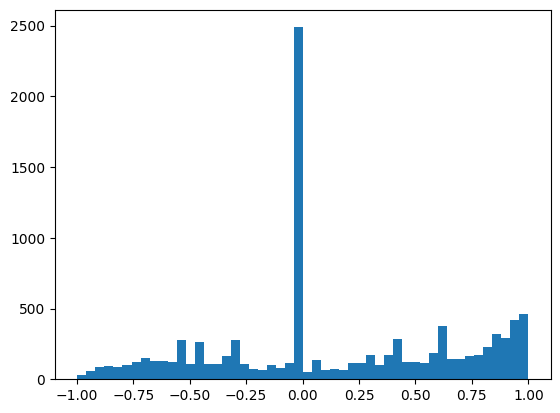

In [10]:
plt.hist(clean_data['COMPOUND'], bins = 50)
plt.show()

In [11]:
clean_data['LABEL'] = clean_data['COMPOUND'].apply(lambda x: 'neg' if x <= -0.05 else ('pos' if x >= 0.05 else 'neu'))
clean_data['LENGTH'] = clean_data['COMMENT'].apply(lambda text: len([el if el != ' ' and el !=  'br' else None for el in text.split(' ')]))

In [12]:
clean_data = clean_data.sort_values(by='COMPOUND', ascending=True)

In [13]:
most_common = [i[0] for i in Counter(clean_data['COMMENT'].values).most_common(150)]

In [14]:
most_common

['❤',
 'yikes',
 '❤❤❤',
 'girl what',
 'oh',
 'what the fuck',
 'i love you colleen',
 'hi',
 'what',
 'girl',
 'girl what is this',
 'i love you',
 'girl…',
 'yikes ',
 'bruh',
 'what the fuck is this',
 'no way',
 'girl ',
 'what is this',
 'what the hell is this',
 'girl what the fuck',
 'oh no',
 'chat is this real',
 '❤️',
 'omg',
 'this has to be a joke',
 'lol',
 'lmao',
 '❤❤',
 'love you colleen ❤',
 'this is unhinged',
 'this cannot be real',
 'wow',
 'love you colleen!',
 '❤❤❤❤',
 '❤❤❤❤❤',
 'what the hell',
 'girl what the fuck is this',
 'i missed you',
 'bye ',
 'what?',
 'oof',
 'um',
 'first',
 'girl   ',
 'you cannot be serious',
 'what a joke',
 'love you colleen ❤️',
 'love you colleen',
 'we love you colleen',
 'i love you ❤',
 'oh hell no',
 'girl what the hell',
 'pathetic',
 'what the actual fuck',
 'what is wrong with you',
 'weirdo',
 'ain’t no way',
 'there’s no way this is real',
 'is this real',
 'queen',
 ' 3',
 'shut up',
 'lmfaooo',
 '🍅🍅🍅🍅🍅🍅',
 'lmaoooo',
 

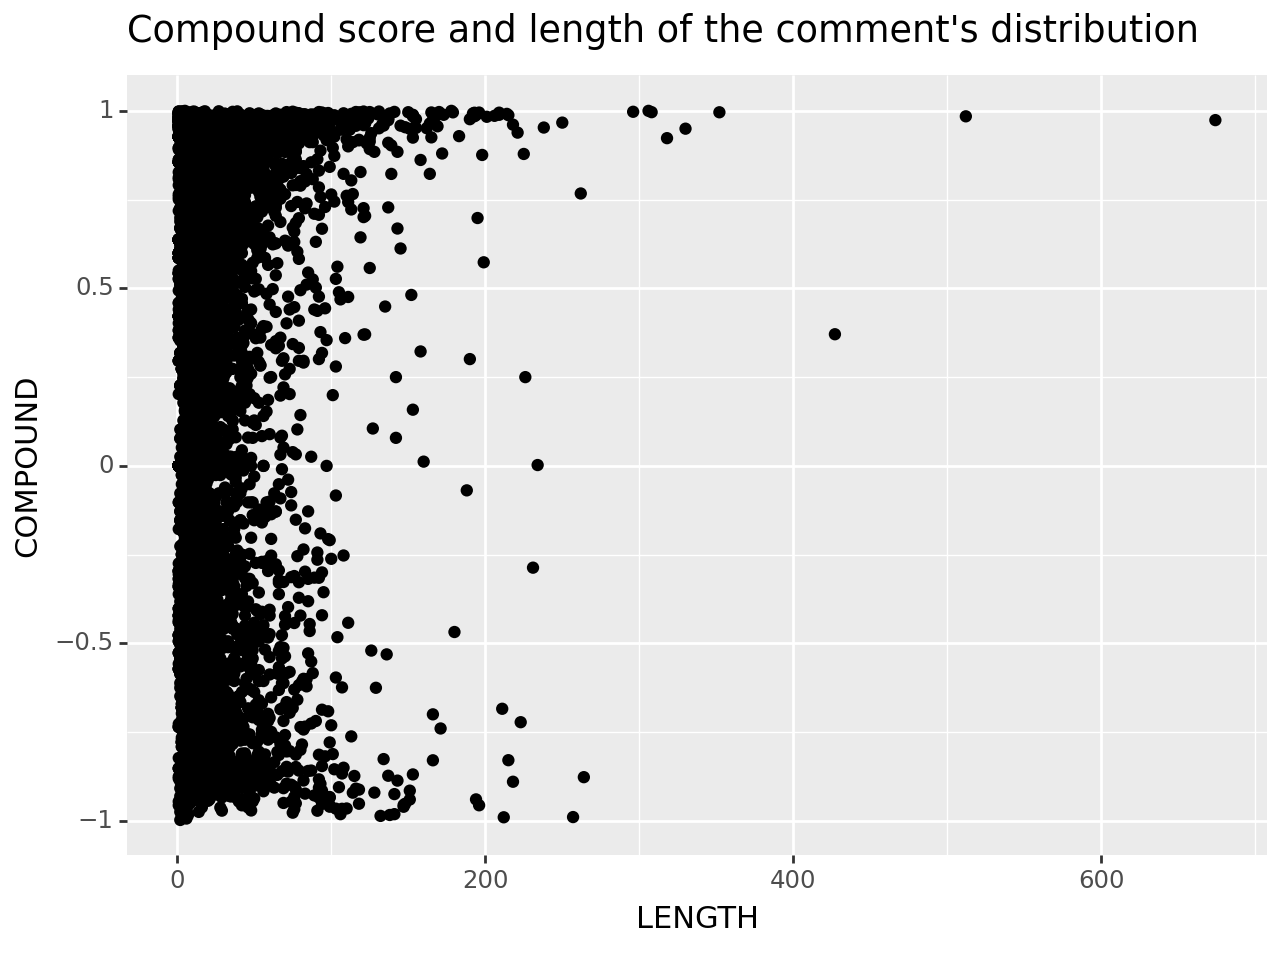

In [15]:
p = ggplot(data=clean_data, mapping=aes(y='COMPOUND', x='LENGTH')) + \
    geom_point() + \
    labs(title='Compound score and length of the comment\'s distribution', y='COMPOUND', x='LENGTH')
print(p)


In [16]:
r = np.corrcoef(clean_data['COMPOUND'], clean_data['LENGTH'])
print("The correlation coefficient between length and compound score is:" + str(r[0, 1])[:6]) #Thankfully, there is little correlation between length and compound.
# Below you can see there are few comments that make it above 200 words, but they are not spam and are actually very useful for this analysis.
# there are a few spam comments but they don't do much harm to the research,
# question, as the spam was meant to be offensive or very positive as a reaction to the video and not to change topic.


The correlation coefficient between length and compound score is:0.1635


In [17]:
clean_data

,COMMENT,COMPOUND,LABEL,LENGTH
5269,what 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭,-0.9971,neg,2
455,the ukelele is killing me 😭😭😭😭😭😭😭😭😭😭😭😭😭😭,-0.9931,neg,6
6958,first every single person in this situation ...,-0.9896,neg,212
7569,seems like people forget there are two sides t...,-0.9890,neg,257
2805,perhaps the comments people are saying about y...,-0.9857,neg,132
...,...,...,...,...
2313,all i want to say is… all i need to say is… ...,0.9986,pos,18
1086,i love you colleen i don t care about what pe...,0.9987,pos,27
7604,i love you i love youi love youi love youi lov...,0.9999,pos,178
5758,sending so much love ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤...,0.9999,pos,5


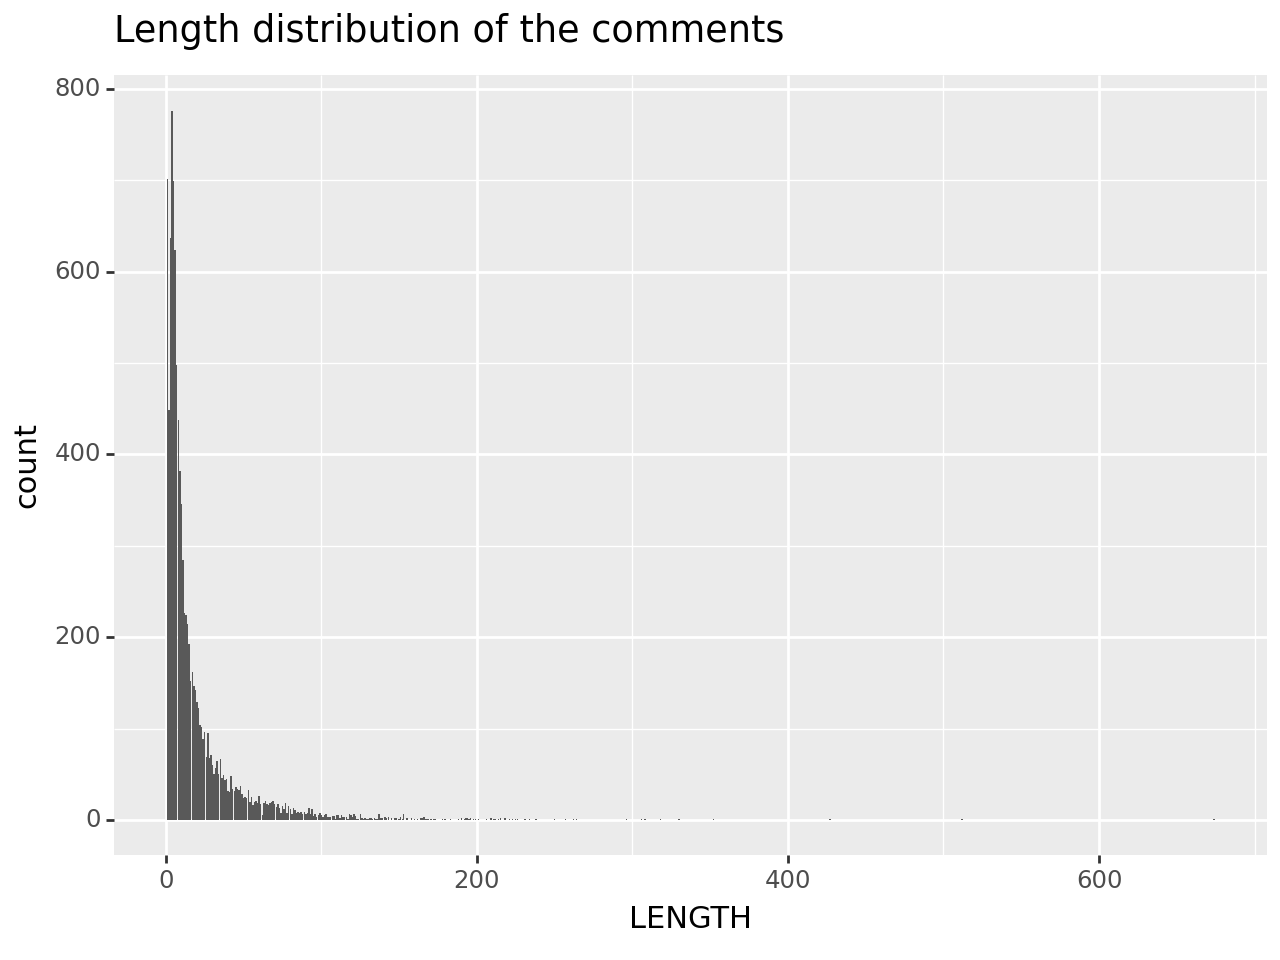

 [[1.         0.16359391]
 [0.16359391 1.        ]]


In [18]:
p = (ggplot(clean_data, aes('LENGTH')) +
     geom_bar() +
     labs(title='Length distribution of the comments')
)
print(p, r)

# Ground truth
To evaluate, I will make ground truth using my own perception of comments. I am aware that my perception might differ from what the authors of the comments have meant, but my perception is by far still better than this model as I could tell.

Sarcasm went often unnoticed - even when it was pretty offensive, take this example:
- "she really thought she ate omg 😂🤡🤡".

It's sarcastic and slang to say that "she [the youtuber] thought she did a good job, oh my god [laughing emoji, clown emoji twice]". Using the clown emoji and using sarcasm went unnoticed, and it had $0.44$ on a scale from $-1$ (negative) to $1$ (positive) as compound score made from negative, neutral and positive scores attributed.

Personally, I believe this model is biased towards negative comments and tends to pick them up as positive even when to humans they could be seen as subtly negative or sarcastic.

# Sampling original comments for human annotation
In order to annotate comments, I need to have the original version with all the punctuation and especially if they used caps lock (which has a different tone of voice), as those elements actually help me better understand the feeling of the original commentor.


In [19]:
with open("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/raw_comments.json", "r") as f:
    to_sample = json.load(f)
    to_sample = pd.DataFrame(to_sample.values())

In [20]:
sample = to_sample.sample(n=1000, replace=False, random_state=25) #25 is the seed
#sample.to_csv('/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/sample_for_groundtruth.csv', index=True)

# Evaluation

In [21]:
test = pd.read_csv("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/BACKUP annotations.csv",
                         header=0, lineterminator='\n', usecols=["Semantic evaluation", 'User ID'], index_col=['User ID'])

In [22]:
test['Comments'] = sample[0]
test = test.reset_index()

In [23]:
to_save = test.reset_index()[['Semantic evaluation', 'Comments']]
to_save.to_csv("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/annotations.csv")

In [24]:
to_save

,Semantic evaluation,Comments
0,-1.0,GIRL REALLY?????
1,1.0,Idk what she did. But i forgive her.
2,-1.0,there’s literally no way this is real
3,-1.0,I vote this the BEST APOLOGY VIDEO of all time...
4,-1.0,new worst YouTube apology vid dropped. Laura l...
...,...,...
995,-1.0,oh she’s done done now fr fr
996,-1.0,Gabbie Hanna is that you?
997,1.0,Colleen we've never met in person but I got to...
998,-1.0,I don’t like how she victimizes herself the wh...


To test:
- each prediction using python will be coded as Positive (if $pos > 0.2$), negative (if $neg > 0.2$) and everything else as neutral
- then, the accuracy metric will be computed based on the 3x3 confusion matrix resulting from this.

In [25]:
def discrete_sentiment_analyzer(sentence):
    score = analyzer.polarity_scores(sentence)
    return round(score['compound'])


In [26]:
# modifying a bit the model so that it fits the definition for the loss function
def discrete_sentiment_analyzer(sentence, printable_output:True):
    score = analyzer.polarity_scores(sentence)

    if printable_output:
        print("{:-<40} {}".format(sentence, str(score)))
    if score['compound'] >= 0.05:
        return 1
    elif score['compound'] <= -0.05 :
        return -1
    return 0  #if score['compound'] is between -0.05 and 0.05, neutral it is!
discrete_sentiment_analyzer("Idk what she did. But i forgive her.", printable_output=True)
discrete_sentiment_analyzer("BZZzzzz", printable_output=True)
discrete_sentiment_analyzer("Hateful", printable_output=True)

Idk what she did. But i forgive her.---- {'neg': 0.122, 'neu': 0.609, 'pos': 0.269, 'compound': 0.3506}
BZZzzzz--------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Hateful--------------------------------- {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4939}


-1

In [27]:
test['predicted'] = [discrete_sentiment_analyzer(comment, printable_output=False) for comment in test['Comments']]

In [28]:
test['Comments'].head(10)

0                                     GIRL REALLY?????
1                 Idk what she did. But i forgive her.
2                there’s literally no way this is real
3    I vote this the BEST APOLOGY VIDEO of all time...
4    new worst YouTube apology vid dropped. Laura l...
5                            I like your video Colleen
6                                    you’re delusional
7                                Are you kidding me?!!
8                            WHAT IS HAPPENING BRO…? 😨
9         What happened to crying in front of a camera
Name: Comments, dtype: object

In [29]:
# Accuracy is the number of diagonal observations on the confusion matrix divided by N. Example:
'''
        predicted Positive Negative Neutral
ground_t
Positive             0       1       1
Negative             1       1       0
Neutral              1       0       1

'''
#it should be when all labels from one dataframe exactly match correspondant from the other
(1+1)/6

0.3333333333333333

In [30]:
mask = test['Semantic evaluation'] == test['predicted']

In [31]:
print(sum(mask.astype(int))/1000)
#that's a low accuracy, but it could've been worse (since there are three labels, if the assignment was really randomic this could've been around 0.333)

0.542


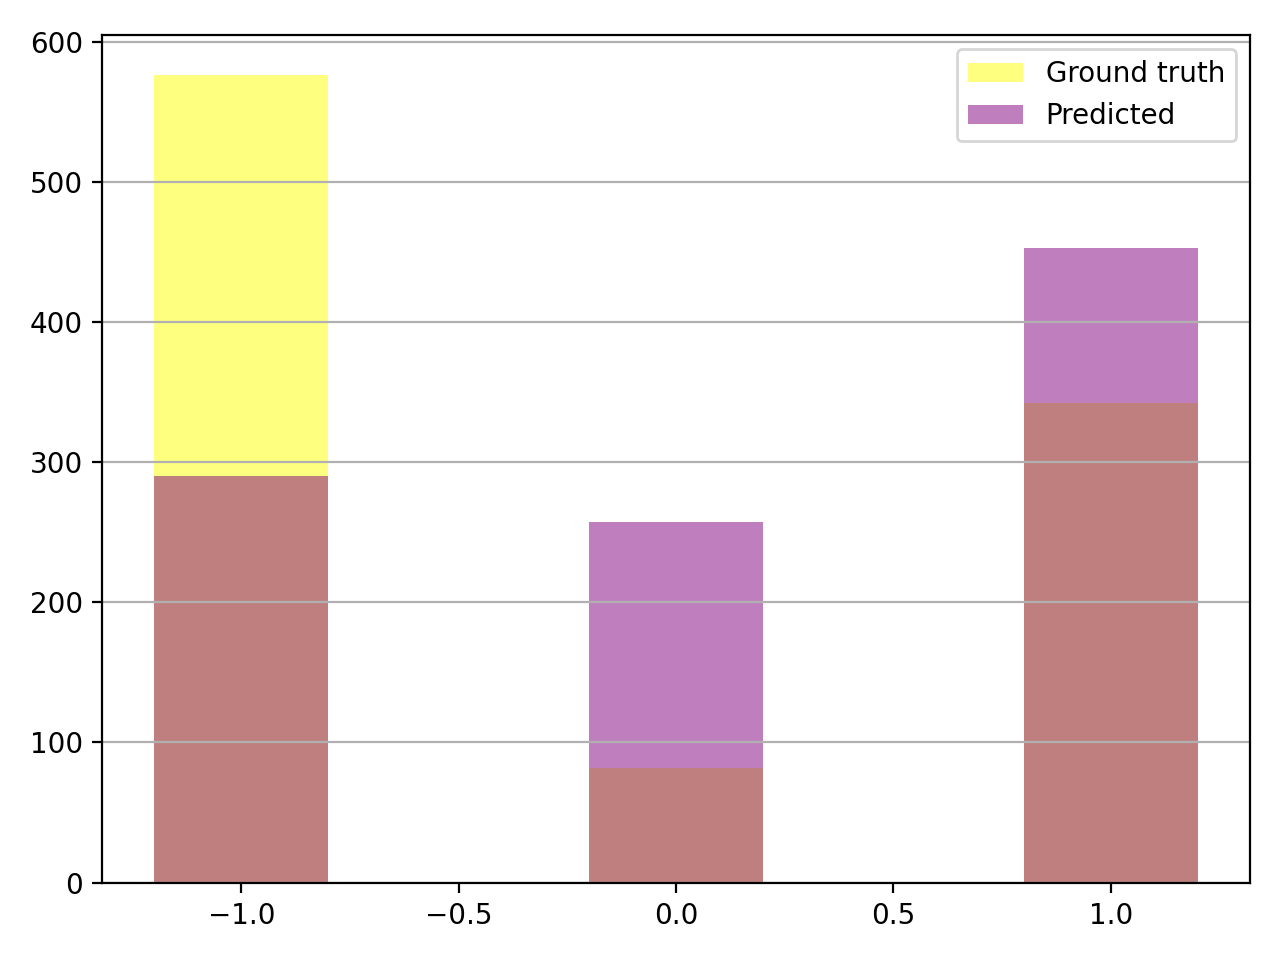

In [32]:
bin_edges = [-1.2, -0.8, -0.2, 0.2, 0.8, 1.2]
plt.hist(test['Semantic evaluation'],bins=bin_edges, alpha=0.5, label="Ground truth", color="yellow")
plt.hist(test['predicted'], bins=bin_edges, alpha=0.5, label="Predicted", color="purple")
plt.grid(axis = 'y')
plt.legend()
plt.tight_layout()
plt.savefig('ground_truth vs predicted.pdf')
plt.show()

In [33]:
true_positives = test[(test.predicted == 1) & (test['Semantic evaluation'] == 1)].shape[0]
false_positives = test[(test.predicted != 1) & (test['Semantic evaluation'] == 1)].shape[0]
print(f"({true_positives} / {true_positives} + {false_positives} = {true_positives / (true_positives + false_positives) :.2f})")

(278 / 278 + 64 = 0.81)


In [34]:

#first is predicted second is semantic evaluation
positive_positive = test[(test.predicted == 1) & (test['Semantic evaluation'] == 1)].shape[0]
positive_neutral = test [(test.predicted == 1) & (test['Semantic evaluation'] == 0)].shape[0]
positive_negative = test[(test.predicted == 1) & (test['Semantic evaluation'] == -1)].shape[0]
neutral_positive = test [(test.predicted == 0) & (test['Semantic evaluation'] == 1)].shape[0]
neutral_neutral = test  [(test.predicted == 0) & (test['Semantic evaluation'] == 0)].shape[0]
neutral_negative = test [(test.predicted == 0) & (test['Semantic evaluation'] == -1)].shape[0]
negative_positive = test[(test.predicted == -1) & (test['Semantic evaluation'] == 1)].shape[0]
negative_neutral = test [(test.predicted == -1) & (test['Semantic evaluation'] == 0)].shape[0]
negative_negative = test[(test.predicted == -1) & (test['Semantic evaluation'] == -1)].shape[0]

hehe = pd.DataFrame({'Pr_negative':[negative_negative, negative_neutral, negative_positive],
              'Pr_neutral':        [neutral_negative, neutral_neutral,   neutral_positive],
              'Pr_positive':       [positive_negative, positive_neutral, positive_positive]},
             index = ['Negative', 'Neutral', 'Positive'])
hehe

,Pr_negative,Pr_neutral,Pr_positive
Negative,231,201,144
Neutral,18,33,31
Positive,41,23,278


In [35]:
(231 + 33 + 278) / 1000

0.542

In [37]:
positive_positive/(negative_positive + neutral_positive + positive_positive)

0.8128654970760234

The ready-to-use python model works well with predicting positive comments, but it does fail with the sarcasm and slang used offensively that is immensely present in the data. I shall also note that I tend to see many comments as less neutral and attribute them to polarize them, likely because I perceive them as sarcastic or sympathetic with Coleen (as in actually heartwarming) but they are expressed in a long and formal way, which might be computed as negative by VADER.  

In [39]:
df

NameError: name 'df' is not defined

# Topic Identification
To do so, Gensim's library for Python Latent Dirichlet Allocation (LDA) will be used.
To find meaningful relationships between topics, the comments will be divided into two exclusive corpuses of analysis:
- negative comments
- positive comments
So that it is possible to know what are people negatively expressing and what are people positively expressing.

Tutorial: [Topic Identification](https://www.analyticsvidhya.com/blog/2022/02/topic-identification-with-gensim-library-using-python/)

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [ ]:
!pip install gensim -q

In [ ]:
from gensim import corpora

In [ ]:
stoplist = set('for a of the and to in this there perhaps'.split())

#texts = [[word for word in comment.lower().split() if word not in stoplist]
#         for document in clean_data['COMMENT']]
def processing(comment):
    res = []
    for word in comment.lower().split():
        if word not in stoplist:
            res.append(word)
    return res
topics = pd.DataFrame()
topics['Comments'] = clean_data['COMMENT'].apply(processing)

In [ ]:
topics.insert(1, "Labels", clean_data['LABEL'])
topics.head()

In [ ]:
from gensim import corpora

documents = ["Human machine interface for lab abc computer applications",
              "A survey of user opinion of computer system response time",
              "The EPS user interface management system",
              "System and human system engineering testing of EPS",
              "Relation of user perceived response time to error measurement",
              "The generation of random binary unordered trees",
              "The intersection graph of paths in trees",
              "Graph minors IV Widths of trees and well quasi ordering",
              "Graph minors A survey"]

In [ ]:


# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

from pprint import pprint  # pretty-printer
pprint(texts)

In [52]:
clean_data[clean_data.COMPOUND < -0.5].COMMENT

5269                        what 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭
455              the ukelele is killing me 😭😭😭😭😭😭😭😭😭😭😭😭😭😭
6958     first  every single person in this situation ...
7569    seems like people forget there are two sides t...
2805    perhaps the comments people are saying about y...
                              ...                        
1801    this video cannot be real you know what you di...
7415    i m taking accountability but also  this is al...
6115                           cancel culture is so weird
2380    i literally haven’t seen something so ridiculo...
2747           be for real now ??? this is mental illness
Name: COMMENT, Length: 1437, dtype: object

In [ ]:
lemmatizer = gensim.utils.lemmatize()